In [1056]:
import keras
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import math
import os
from keras.layers import *
from keras.models import *
from keras.optimizers import *

In [1057]:
MANIFEST_DIR = r'C:\Users\Administrator\Desktop\test\frftdata\train\frfttrain1.0.csv'
Batch_size = 30
Long = 800
Lens = 200
def convert2oneHot(index, lens):
    hot = np.zeros((lens,))
    hot[int(index)] = 1
    return(hot)


In [1058]:
def xs_gen(path=MANIFEST_DIR, batch_size=Batch_size, train=True, Lens=Lens):
    img_list = pd.read_csv(path)
    if train:
        img_list = np.array(img_list)[:Lens]
        print("Found %s train items." % len(img_list))
        print("list 1 is", img_list[0, -1])
        steps = math.ceil(len(img_list) / batch_size)
    else:
        img_list = np.array(img_list)[Lens:]
        print("Found %s test items." % len(img_list))
        print("list 1 is", img_list[0, -1])
        steps = math.ceil(len(img_list) / batch_size)
    while True:
        for i in range(steps):
            batch_list = img_list[i * batch_size: i * batch_size + batch_size]
            np.random.shuffle(batch_list)
            batch_x = np.array([file for file in batch_list[:, 1:-1]])
            batch_y = np.array([convert2oneHot(label, 4) for label in batch_list[:, -1]])
            yield batch_x, batch_y


TEST_MANIFEST_DIR = r'C:\Users\Administrator\Desktop\test\frftdata\test\frfttest1.0.csv'

In [1059]:
def ts_gen(path=TEST_MANIFEST_DIR, batch_size=Batch_size):
    img_list = pd.read_csv(path)
    img_list = np.array(img_list)[:Lens]
    print("Found %s test items." % len(img_list))
    print("list 1 is", img_list[0, -1])
    steps = math.ceil(len(img_list) / batch_size)
    while True:
        for i in range(steps):
            batch_list = img_list[i * batch_size:i * batch_size + batch_size]
            batch_x = np.array([file for file in batch_list[:, 1:]])
            yield batch_x


TIME_PERIODS = 5000


In [1060]:
def build_model(input_shape=(TIME_PERIODS,), num_classes=4):
    model = Sequential()
    model.add(Reshape((TIME_PERIODS, 1), input_shape=input_shape))

    model.add(Conv1D(16, 8, strides=2, activation='relu', input_shape=(TIME_PERIODS, 1)))
    model.add(Conv1D(16, 8, strides=2, activation='relu', padding="same"))
    model.add(MaxPooling1D(2))

    model.add(Conv1D(64, 4, strides=2, activation='relu', padding="same"))
    model.add(Conv1D(64, 4, strides=2, activation='relu', padding="same"))
    model.add(MaxPooling1D(2))

    model.add(Conv1D(256, 4, strides=2, activation='relu', padding="same"))
    model.add(Conv1D(256, 4, strides=2, activation='relu', padding="same"))
    model.add(MaxPooling1D(2))

    model.add(Conv1D(512, 2, strides=1, activation='relu', padding="same"))
    model.add(Conv1D(512, 2, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2))

    """ model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))"""

    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    return(model)


Train = True

In [1061]:
if __name__ == "__main__":
    if Train == True:
        train_iter = xs_gen()
        val_iter = xs_gen(train=False)

        ckpt = keras.callbacks.ModelCheckpoint(
            filepath='best_model.{epoch:02d}-{val_loss:.4f}.h5',
            monitor='val_loss', save_best_only=True, verbose=1
        )

        model = build_model()
        opt = Adam(0.0002)
        model.compile(loss='categorical_crossentropy',
                      optimizer = opt, metrics=['accuracy'])
        print(model.summary())

        train_history = model.fit_generator(
            generator=train_iter,
            steps_per_epoch=Lens // Batch_size,
            epochs=25,
            initial_epoch=0,
            validation_data=val_iter,
            validation_steps=(Long - Lens) // Batch_size,
            callbacks=[ckpt],
        )

        model.save("finishModel.h5")
    else:
        test_iter = ts_gen()
        model = load_model("best_model.49-0.00.h5")
        pres = model.predict_generator(generator=test_iter, steps=math.ceil(528 / Batch_size), verbose=1)
        print(pres.shape)
        ohpres = np.argmax(pres, axis=1)
        print(ohpres.shape)
        df = pd.DataFrame()
        df["id"] = np.arange(1, len(ohpres) + 1)
        df["label"] = ohpres
        df.to_csv("predicts.csv", index=None)
        test_iter = ts_gen()
        for x in test_iter:
            x1 = x[0]
            break
        plt.plot(x1)
        plt.show()


Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_81 (Reshape)         (None, 5000, 1)           0         
_________________________________________________________________
conv1d_648 (Conv1D)          (None, 2497, 16)          144       
_________________________________________________________________
conv1d_649 (Conv1D)          (None, 1249, 16)          2064      
_________________________________________________________________
max_pooling1d_324 (MaxPoolin (None, 624, 16)           0         
_________________________________________________________________
conv1d_650 (Conv1D)          (None, 312, 64)           4160      
_________________________________________________________________
conv1d_651 (Conv1D)          (None, 156, 64)           16448     
_________________________________________________________________
max_pooling1d_325 (MaxPoolin (None, 78, 64)          

Epoch 20/25
6/6 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000
Epoch 00020: val_loss improved from 0.00323 to 0.00261, saving model to best_model.20-0.0026.h5
6/6 [==============================] - 1s 159ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 21/25
6/6 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000
Epoch 00021: val_loss improved from 0.00261 to 0.00223, saving model to best_model.21-0.0022.h5
6/6 [==============================] - 1s 155ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 22/25
6/6 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000
Epoch 00022: val_loss improved from 0.00223 to 0.00201, saving model to best_model.22-0.0020.h5
6/6 [==============================] - 1s 166ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 23/25
6/6 [=============================

In [1062]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.ylabel('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

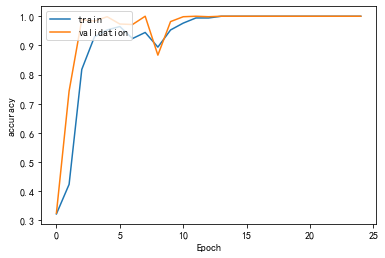

In [1063]:
show_train_history(train_history, 'accuracy', 'val_accuracy')

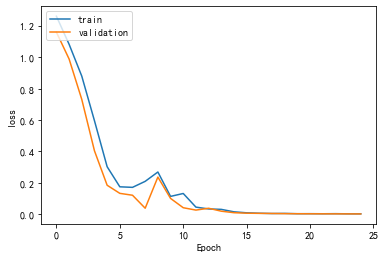

In [1064]:
show_train_history(train_history, 'loss', 'val_loss')

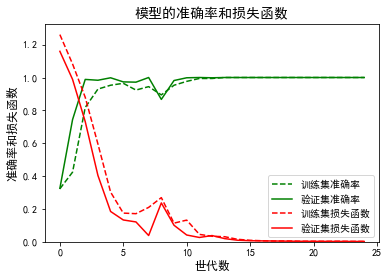

In [1065]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(6, 4))
plt.plot(train_history.history['accuracy'], "g--", label="训练集准确率")
plt.plot(train_history.history['val_accuracy'], "g", label="验证集准确率")
plt.plot(train_history.history['loss'], "r--", label="训练集损失函数")
plt.plot(train_history.history['val_loss'], "r", label="验证集损失函数")
plt.title('模型的准确率和损失函数', fontsize=14)
plt.ylabel('准确率和损失函数', fontsize=12)
plt.xlabel('世代数', fontsize=12)
plt.ylim(0)
plt.legend()
plt.show()

In [1066]:
testdata = train_history.history['val_accuracy']
df = pd.DataFrame(testdata)
df.to_csv(r'C:\Users\Administrator\Desktop\daochu.csv')

In [1114]:
file = r"C:\Users\Administrator\Desktop\shiyong22.csv"

In [1115]:
all_df = pd.read_csv(file)

In [1116]:
ndarray = all_df.values

In [1117]:
ndarray[:2]

array([[1],
       [1]], dtype=int64)

In [1118]:
test_iter = ts_gen()
pres = model.predict_generator(generator=test_iter, steps=math.ceil(520 / Batch_size), verbose=1)
print(pres.shape)

Found 200 test items.
list 1 is 2.018626134
18/18 [==============================] - 0s 17ms/step
(520, 4)


In [1119]:
print(ndarray.shape)

(200, 1)


In [1120]:
ohpres = np.argmax(pres, axis=1)
print(ohpres.shape)
ohpres=ohpres[:200]
ohpres

(520,)


array([0, 0, 1, 1, 0, 0, 1, 1, 1, 3, 0, 3, 0, 1, 0, 0, 3, 3, 2, 1, 2, 3,
       3, 2, 0, 2, 2, 1, 3, 2, 3, 1, 2, 3, 0, 2, 3, 2, 1, 0, 1, 0, 0, 2,
       3, 3, 1, 2, 1, 1, 3, 0, 2, 1, 2, 1, 3, 2, 3, 1, 2, 3, 1, 0, 0, 2,
       2, 2, 2, 2, 0, 1, 0, 3, 2, 2, 3, 1, 3, 1, 3, 1, 0, 3, 1, 0, 3, 1,
       3, 2, 2, 0, 1, 3, 3, 2, 3, 3, 2, 2, 2, 2, 3, 1, 2, 0, 0, 0, 0, 2,
       2, 0, 0, 2, 1, 3, 3, 1, 0, 2, 1, 0, 0, 0, 1, 3, 0, 2, 1, 1, 0, 1,
       0, 1, 3, 2, 3, 2, 3, 0, 0, 1, 3, 3, 1, 2, 0, 3, 3, 0, 3, 0, 2, 1,
       1, 3, 1, 2, 0, 1, 1, 0, 0, 0, 1, 3, 0, 2, 1, 1, 0, 1, 0, 1, 3, 2,
       3, 2, 3, 0, 0, 1, 3, 3, 1, 2, 0, 3, 3, 0, 3, 0, 2, 1, 1, 3, 1, 2,
       0, 1], dtype=int64)

In [1121]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def cm_plot(original_label, predict_label, pic=None):
    cm = confusion_matrix(original_label, predict_label)
    plt.figure()
    plt.matshow(cm, cmap=plt.cm.GnBu)
    plt.colorbar()
    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(cm[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center')
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    plt.title('Confusion Matrix')
    if pic is not None:
        plt.savefig(str(pic) + '.jpg')
    plt.show()

<Figure size 432x288 with 0 Axes>

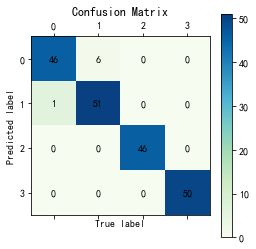

In [1122]:
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
cm_plot(ndarray, ohpres)

In [1104]:
from sklearn.metrics import accuracy_score
accuracy_score(ndarray, ohpres)

0.96

In [1034]:
train_history.history['loss']

[1.3808166980743408,
 1.3577184677124023,
 1.2972100973129272,
 1.216436505317688,
 1.1809911727905273,
 1.132028341293335,
 1.0613418817520142,
 0.9857239723205566,
 0.835960865020752,
 0.780597984790802,
 0.6921771764755249,
 0.651037871837616,
 0.5477163195610046,
 0.5168696045875549,
 0.4617786705493927,
 0.4813087582588196,
 0.4515032172203064,
 0.4019736349582672,
 0.35730981826782227,
 0.3141750991344452,
 0.39422404766082764,
 0.400638610124588,
 0.4012707471847534,
 0.33461132645606995,
 0.3260943591594696]

In [711]:
train_history.history['val_loss']

[4.414752006530762,
 1.4087058305740356,
 1.3884167671203613,
 1.3898876905441284,
 1.3898757696151733,
 1.389997124671936,
 1.3876137733459473,
 1.388262391090393,
 1.388336181640625,
 1.38800847530365,
 1.388262391090393,
 1.3875138759613037,
 1.3881995677947998,
 1.3891583681106567,
 1.3886951208114624,
 1.387660264968872,
 1.387418508529663,
 1.3875999450683594,
 1.3876866102218628,
 1.3884252309799194,
 1.388853669166565,
 1.388655662536621,
 1.3883846998214722,
 1.38779878616333,
 1.3875389099121094]

In [712]:
train_history.history['val_accuracy']

[0.25,
 0.2516666650772095,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158,
 0.24500000476837158]

In [713]:
train_history.history['accuracy']

[0.23333333432674408,
 0.29411765933036804,
 0.23529411852359772,
 0.24705882370471954,
 0.25294119119644165,
 0.30588236451148987,
 0.24705882370471954,
 0.2666666805744171,
 0.25294119119644165,
 0.25294119119644165,
 0.30000001192092896,
 0.23529411852359772,
 0.29411765933036804,
 0.25294119119644165,
 0.28333333134651184,
 0.25882354378700256,
 0.29411765933036804,
 0.20588235557079315,
 0.2823529541492462,
 0.33529412746429443,
 0.25294119119644165,
 0.30000001192092896,
 0.24117647111415863,
 0.24117647111415863,
 0.2647058963775635]